# IMAGE CLASSIFICATION TO PREDICT FINANCIAL MARKET TRENDS

In [2]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pickle
from datetime import datetime, timedelta
from pytz import timezone
import requests
import time
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import random
import cv2
import tensorflow as tf
import tensorflow.keras.layers as tfkl
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    BatchNormalization,
    Dropout,
    Input,
    GlobalAveragePooling2D,
)
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Ignore warnings
import warnings

warnings.filterwarnings("ignore")

# Set seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)


## Table of contents:
### 1. Collect the data
### 2. Create train and test sets
### 3. Create images (1)
### 4. Create images (2)
### 5. CNN
### 6. Trading strategy


### 1. Collect the data

In [67]:
# list of the price information we want to collect 
his_ls = ['date', 'open', 'high', 'low', 'close', 'volume']

# list of possible tickers we can use (for all these tickers it is possible to download the price data through the following link and API)
tickers= ["CL", "BZ", "NG","SI", "PL","ZS","ZM","KC", "SB", "CC", "LE", "GF", "HE", "DC", "LB","SP"]


api_key = 'TOXuLzo1ybRJs0Fp4pEQxeqhI6AgGr7c'

In [68]:
datasets = {}

for ticker in tickers:
    url = f'https://financialmodelingprep.com/api/v3/historical-price-full/{ticker}?apikey={api_key}&from=1930-01-01&to=2023-11-10'
    r = requests.get(url)
    packages_json = r.json()
    length = len(packages_json['historical'])
    df = pd.DataFrame(np.zeros((length, 6)), columns = his_ls)
    for i, j in zip(range(length - 1, -1, -1), range(0, length)):
            for k in his_ls:
                df[k].iloc[i] = packages_json['historical'][j][k]
    
    datasets[ticker] = df

In [161]:
for ticker in tickers:
    # calculate the range between the closing and the opening price of the commodity

    datasets[ticker]['realbody'] = datasets[ticker]['close'] - datasets[ticker]['open']
    datasets[ticker] = datasets[ticker].reset_index()

    #add a column that computes the moving average of 5 days
    datasets[ticker]['moving_average_5'] = datasets[ticker]['close'].rolling(5).mean()

    # add a column that computes the moving average of 50 days
    datasets[ticker]['moving_average_50'] = datasets[ticker]['close'].rolling(50).mean()

    # add a column that computes the moving average of 200 days
    datasets[ticker]['moving_average_200'] = datasets[ticker]['close'].rolling(200).mean()

    # Calculate the 'open' price for the next day and the 'close' price for 6 days later
    datasets[ticker]['open_tomorrow'] = datasets[ticker]['open'].shift(-1)
    datasets[ticker]['close_20_days_after'] = datasets[ticker]['close'].shift(-20) # decided to use a time frame of 6 days

    # delete all rows having nan values on open_tomorrow or close_6_days_after
    datasets[ticker] = datasets[ticker].dropna(subset=['open_tomorrow', 'close_20_days_after'])

    # empirical method labeling
    datasets[ticker]['predictions'] = [
        1 if (row.close_20_days_after - row.open_tomorrow) >0 else
        0 for row in datasets[ticker].itertuples()]

datasets["CL"].head()

,level_0,index,date,open,high,low,close,volume,realbody,moving_average_5,moving_average_50,moving_average_200,open_tomorrow,close_20_days_after,predictions
0,0,0,1973-05-02,0.00,2.00,1.97,2.00,672000.0,2.00,NaN,NaN,NaN,2.00,1.79,0
1,1,1,1973-05-03,2.00,2.01,1.95,2.01,739200.0,0.01,NaN,NaN,NaN,2.01,1.74,0
2,2,2,1973-05-04,2.01,2.03,1.99,2.00,1339200.0,-0.01,NaN,NaN,NaN,2.00,1.66,0
3,3,3,1973-05-07,2.00,2.02,1.98,1.99,316800.0,-0.01,NaN,NaN,NaN,1.99,1.62,0
4,4,4,1973-05-08,1.99,1.99,1.95,1.99,619200.0,0.00,1.998,NaN,NaN,1.99,1.54,0


### 2. Create train and test sets

In [28]:
# define a train and test set

datasets_train = {}
datasets_test = {}

for ti, df in datasets.items():
    df = df.reset_index()
    df['date'] = df['date'].astype('datetime64[ns]')
    date = datetime.datetime(2015, 12, 31)

    df_train = df[df["date"] <= date].drop("index", axis = 1)
    df_test = df[df["date"] > date].drop("index", axis = 1)

    # drop the first 4 rows of the train and test datasets since the moving average is a NaN value
    df_train = df_train.dropna(subset = ["moving_average_5"])
    df_test = df_test.dropna(subset = ["moving_average_5"])

    # drop the first 4 rows of the train and test datasets since the moving average is a NaN value
    df_train = df_train.dropna(subset = ["moving_average_50"])
    df_test = df_test.dropna(subset = ["moving_average_50"])

    # drop the first 4 rows of the train and test datasets since the moving average is a NaN value
    df_train = df_train.dropna(subset = ["moving_average_200"])
    df_test = df_test.dropna(subset = ["moving_average_200"])

    datasets_train[ti] = df_train
    datasets_test[ti] = df_test



In [29]:
datasets_train["CL"].head()

,level_0,date,open,high,low,close,volume,realbody,moving_average_5,moving_average_50,moving_average_200,open_tomorrow,close_6_days_after,predictions
199,199,1974-02-12,1.50,1.55,1.50,1.50,428800.0,0.00,1.520,1.5442,1.84055,1.50,1.76,1
200,200,1974-02-13,1.50,1.51,1.48,1.51,329600.0,0.01,1.506,1.5410,1.83810,1.51,1.73,1
201,201,1974-02-14,1.51,1.53,1.51,1.51,332800.0,0.00,1.504,1.5378,1.83560,1.51,1.73,1
202,202,1974-02-18,1.51,1.54,1.51,1.51,484800.0,0.00,1.506,1.5318,1.83315,1.51,1.68,1
203,203,1974-02-19,1.51,1.53,1.50,1.52,680000.0,0.01,1.510,1.5262,1.83080,1.52,1.70,1


In [30]:
len(datasets_test["CL"])

1959

In [31]:
labels_train = {}
for ticker in tickers:
    labels_train[ticker] = np.array(datasets_train[ticker]["predictions"][20:])


labels_test = {}
for ticker in tickers:
    labels_test[ticker] = np.array(datasets_test[ticker]["predictions"][20:])

In [32]:
y_test = np.concatenate(list(labels_test.values()))
y_train = np.concatenate(list(labels_train.values()))

### 3. Create images (1)

In this section, we will construct individual layers comprising distinct financial attributes, with each final composite image representing the culmination of six different layers. Each layer corresponds to a specific financial characteristic intended for inclusion in the analysis. 
The considered elements are:
- candlestick bodies;
- candlestick wicks;
- 5-day moving average;
- 50-day moving average;
- 200-day moving average;
- trading volumes.

The six functions that follow, respect all the same structure and each of them generates a visual representation of financial attributes for a given financial sample.

Each function:
- Extract Max and Min Values: It extracts the maximum and minimum values over various columns in the input data frame (sample). The columns include 'close', 'open', 'high', 'low', 'moving_average_5', 'moving_average_50', and 'moving_average_200'.
- Discretize Values: It discretizes the values into top_height bins (default is 64 bins) linearly spread between the minimum and maximum values obtained in the previous step.
- Digitize Closing and Opening Prices: It digitizes the closing and opening prices of the financial sample based on the calculated bins.
- Initialize Matrix: It initializes a matrix (top) with all grey background (value 128).
- Loop Over Days: For each day (iteration in the loop), it does the following:
    - It calculates the indices for left, right, and middle pixels for the current day.
    - It sets the pixels in the matrix top to represent the chart for that day.

- Flip the Matrix: It flips the matrix vertically because the representation is built from the bottom to the top, whereas in a standard plot, the first row corresponds to the bottom.
- Return Result: the function returns the generated chart as a 2D NumPy array.

In [168]:
# Candlesticks code

def create_candlestick(sample, n_days, top_height= 64):
    # Extract max and min values over High, Low, Open, Close, and MA
    max_val = max(sample[['close', 'open', 'high', 'low', 'moving_average_5', 'moving_average_50', 'moving_average_200']].max())
    min_val = min(sample[['close', 'open', 'high', 'low', 'moving_average_5', 'moving_average_50', 'moving_average_200']].min())

    # Discretize values into n bins where n = top_height and bins are linearly spread over [min, max]
    bins = np.linspace(min_val, max_val, top_height)

    close_bins = np.digitize(np.array(sample.close), bins) - 1  # discretize normalized closing prices numbers
    open_bins = np.digitize(np.array(sample.open), bins) - 1  # discretize normalized opening prices numbers

    # Get indexes left, right, middle pixels
    left_pixels = [0 + i for i in range(0, 4 * n_days, 4)]
    right_pixels = [2 + i for i in range(0, 4 * n_days, 4)]
    middle_pixels = [1 + i for i in range(0, 4 * n_days, 4)]
    

    # initialize matrix with all grey background
    top = np.ones((top_height, 4 * n_days, 1)) * 128

    for i in range(n_days):
        # Add white pixel in left column for each day at height = opening value for that day
        #top[low_bins[i]:high_bins[i] + 1, middle_pixels[i]] = [255, 255, 255]
        top[open_bins[i]:close_bins[i] + 1, left_pixels[i]] = 255 # White for open
        top[open_bins[i]:close_bins[i] + 1, right_pixels[i]] = 255
        top[open_bins[i]:close_bins[i] + 1, middle_pixels[i]] = 255
        top[close_bins[i]:open_bins[i] + 1, left_pixels[i]] = 0  # Black for close
        top[close_bins[i]:open_bins[i] + 1, right_pixels[i]] = 0
        top[close_bins[i]:open_bins[i] + 1, middle_pixels[i]] = 0


    # flip as we row 0 is now the first row while we want it to be the bottom one
    top = np.flip(top, 0)

    return top

In [169]:
# 5-days moving average code


def create_moving_average(sample, n_days, top_height=64):
    # Extract max and min values over High, Low, Open, Close, and MA
    max_val = max(sample[['close', 'open', 'high', 'low', 'moving_average_5', 'moving_average_50', 'moving_average_200']].max())
    min_val = min(sample[['close', 'open', 'high', 'low', 'moving_average_5', 'moving_average_50', 'moving_average_200']].min())

    # Discretize values into n bins where n = top_height and bins are linearly spread over [min, max]
    bins = np.linspace(min_val, max_val, top_height)

    close_bins = np.digitize(np.array(sample.close), bins) - 1  # discretize normalized closing prices numbers
    open_bins = np.digitize(np.array(sample.open), bins) - 1  # discretize normalized opening prices numbers
    high_bins = np.digitize(np.array(sample.high), bins) - 1  # discretize normalized highest prices numbers
    low_bins = np.digitize(np.array(sample.low), bins) - 1  # discretize normalized lowest prices numbers
    ma_bins = np.digitize(np.array(sample.moving_average_5), bins) - 1  # discretize normalized ma prices numbers

    # Get indexes left, right, middle pixels
    left_pixels = [0 + i for i in range(0, 4 * n_days, 4)]
    right_pixels = [2 + i for i in range(0, 4 * n_days, 4)]
    middle_pixels = [1 + i for i in range(0, 4 * n_days, 4)]
    space_pixels = [3 + i for i in range(0, 4 * n_days, 4)]


    # initialize matrix with all grey background
    top = np.ones((top_height, 4 * n_days)) * 128

    for i in range(n_days):
        
        # Add white pixel in left, right, middle column at height = MA value for that day
        top[ma_bins[i], left_pixels[i]] = 50
        top[ma_bins[i], middle_pixels[i]] = 50
        top[ma_bins[i], right_pixels[i]] = 50

    # flip as we row 0 is now the first row while we want it to be the bottom one
    top = np.flip(top, 0)

    return top

In [170]:
# 50-days moving average code


def create_moving_average_50(sample, n_days, top_height=64):
    # Extract max and min values over High, Low, Open, Close, and MA
    max_val = max(sample[['close', 'open', 'high', 'low', 'moving_average_5', 'moving_average_50', 'moving_average_200']].max())
    min_val = min(sample[['close', 'open', 'high', 'low', 'moving_average_5', 'moving_average_50', 'moving_average_200']].min())

    # Discretize values into n bins where n = top_height and bins are linearly spread over [min, max]
    bins = np.linspace(min_val, max_val, top_height)

    close_bins = np.digitize(np.array(sample.close), bins) - 1  # discretize normalized closing prices numbers
    open_bins = np.digitize(np.array(sample.open), bins) - 1  # discretize normalized opening prices numbers
    high_bins = np.digitize(np.array(sample.high), bins) - 1  # discretize normalized highest prices numbers
    low_bins = np.digitize(np.array(sample.low), bins) - 1  # discretize normalized lowest prices numbers
    ma_bins = np.digitize(np.array(sample.moving_average_50), bins) - 1  # discretize normalized ma prices numbers

    # Get indexes left, right, middle pixels
    left_pixels = [0 + i for i in range(0, 4 * n_days, 4)]
    right_pixels = [2 + i for i in range(0, 4 * n_days, 4)]
    middle_pixels = [1 + i for i in range(0, 4 * n_days, 4)]
    space_pixels = [3 + i for i in range(0, 4 * n_days, 4)]

    # initialize matrix with all grey background
    top = np.ones((top_height, 4 * n_days)) * 128

    for i in range(n_days):
        
        # Add white pixel in left, right, middle column at height = MA value for that day
        top[ma_bins[i], left_pixels[i]] = 200
        top[ma_bins[i], middle_pixels[i]] = 200
        top[ma_bins[i], right_pixels[i]] = 200

    # flip as we row 0 is now the first row while we want it to be the bottom one
    top = np.flip(top, 0)

    return top

In [171]:
# 200-days movig average code


def create_moving_average_200(sample, n_days, top_height=64):
    # Extract max and min values over High, Low, Open, Close, and MA
    max_val = max(sample[['close', 'open', 'high', 'low', 'moving_average_5', 'moving_average_50', 'moving_average_200']].max())
    min_val = min(sample[['close', 'open', 'high', 'low', 'moving_average_5', 'moving_average_50', 'moving_average_200']].min())

    # Discretize values into n bins where n = top_height and bins are linearly spread over [min, max]
    bins = np.linspace(min_val, max_val, top_height)

    close_bins = np.digitize(np.array(sample.close), bins) - 1  # discretize normalized closing prices numbers
    open_bins = np.digitize(np.array(sample.open), bins) - 1  # discretize normalized opening prices numbers
    high_bins = np.digitize(np.array(sample.high), bins) - 1  # discretize normalized highest prices numbers
    low_bins = np.digitize(np.array(sample.low), bins) - 1  # discretize normalized lowest prices numbers
    ma_bins = np.digitize(np.array(sample.moving_average_200), bins) - 1  # discretize normalized ma prices numbers

    # Get indexes left, right, middle pixels
    left_pixels = [0 + i for i in range(0, 4 * n_days, 4)]
    right_pixels = [2 + i for i in range(0, 4 * n_days, 4)]
    middle_pixels = [1 + i for i in range(0, 4 * n_days, 4)]
    space_pixels = [3 + i for i in range(0, 4 * n_days, 4)]


    # initialize matrix with all grey background
    top = np.ones((top_height, 4 * n_days)) * 128

    for i in range(n_days):
        
        # Add white pixel in left, right, middle column at height = MA value for that day
        top[ma_bins[i], left_pixels[i]] = 245
        top[ma_bins[i], middle_pixels[i]] = 245
        top[ma_bins[i], right_pixels[i]] = 245

    # flip as we row 0 is now the first row while we want it to be the bottom one
    top = np.flip(top, 0)

    return top

In [172]:
# Wicks code

def create_wicks(sample, n_days, top_height=64):
    # Extract max and min values over High, Low, Open, Close, and MA
    max_val = max(sample[['close', 'open', 'high', 'low', 'moving_average_5', 'moving_average_50', 'moving_average_200']].max())
    min_val = min(sample[['close', 'open', 'high', 'low', 'moving_average_5', 'moving_average_50', 'moving_average_200']].min())

    # Discretize values into n bins where n = top_height and bins are linearly spread over [min, max]
    bins = np.linspace(min_val, max_val, top_height)

    close_bins = np.digitize(np.array(sample.close), bins) - 1  # discretize normalized closing prices numbers
    open_bins = np.digitize(np.array(sample.open), bins) - 1  # discretize normalized opening prices numbers
    high_bins = np.digitize(np.array(sample.high), bins) - 1  # discretize normalized highest prices numbers
    low_bins = np.digitize(np.array(sample.low), bins) - 1  # discretize normalized lowest prices numbers
    ma_bins = np.digitize(np.array(sample.moving_average_5), bins) - 1  # discretize normalized ma prices numbers

    # Get indexes left, right, middle pixels
    left_pixels = [0 + i for i in range(0, 4 * n_days, 4)]
    right_pixels = [2 + i for i in range(0, 4 * n_days, 4)]
    middle_pixels = [1 + i for i in range(0, 4 * n_days, 4)]
    space_pixels = [3 + i for i in range(0, 4 * n_days, 4)]

    # TOP (MA and OHCL chart)

    # initialize matrix with all grey background
    top = np.ones((top_height, 4 * n_days)) * 128

    for i in range(n_days):
        # Add white pixel in left column for each day at height = opening value for that day
        top[low_bins[i]:high_bins[i] + 1, middle_pixels[i]] = 100

    # flip as we row 0 is now the first row while we want it to be the bottom one
    top = np.flip(top, 0)

    return top


In [173]:
# Volume code


def create_volumes(sample, n_days, top_height=64, bottom_height=5):
    # Extract max and min values over High, Low, Open, Close, and MA
    max_val = max(sample[['close', 'open', 'high', 'low', 'moving_average_5', 'moving_average_50', 'moving_average_200']].max())
    min_val = min(sample[['close', 'open', 'high', 'low', 'moving_average_5', 'moving_average_50', 'moving_average_200']].min())

    # Discretize values into n bins where n = top_height and bins are linearly spread over [min, max]
    bins = np.linspace(min_val, max_val, top_height)

    close_bins = np.digitize(np.array(sample.close), bins) - 1  # discretize normalized closing prices numbers
    open_bins = np.digitize(np.array(sample.open), bins) - 1  # discretize normalized opening prices numbers
    high_bins = np.digitize(np.array(sample.high), bins) - 1  # discretize normalized highest prices numbers
    low_bins = np.digitize(np.array(sample.low), bins) - 1  # discretize normalized lowest prices numbers
    ma_bins = np.digitize(np.array(sample.moving_average_5), bins) - 1  # discretize normalized ma prices numbers

    # Get indexes left, right, middle pixels
    left_pixels = [0 + i for i in range(0, 4 * n_days, 4)]
    right_pixels = [2 + i for i in range(0, 4 * n_days, 4)]
    middle_pixels = [1 + i for i in range(0, 4 * n_days, 4)]
    space_pixels = [3 + i for i in range(0, 4 * n_days, 4)]

   
    ## BOTTOM (Volume)

    # Discretize values in n bins where n = bottom_height and bins are linearly spread between min(vol), max(vol)
    volume = np.array(sample.volume)
    vol_bins = np.digitize(volume, bins=np.linspace(min(volume), max(volume), bottom_height)) - 1

    # initialize matrix with all zeros
    bottom = np.ones((51, 4 * n_days)) * 128 #grey background

    for i in range(n_days):
        # Add black pixel in middle column for each day for height in [0, vol] for that day
        bottom[0:vol_bins[i] + 1, middle_pixels[i]] = 150

    # flip
    bottom = np.flip(bottom, 0)

    return bottom

The following code is used to take 20-days information from the initial dataset and feed it to the chosen "chart_type" function which is one of the functions defined above.


In [174]:
def transform_df(df, chart_type, n_days,height):
      image_array = None #initializing the image array
      top_height = int(height*(4/5)) #number of vertical pixels (for price data)
      
      for i in range(len(df)-n_days): #the range is chosen to stop lopping when there are no more 20-days ahead observation
            sample = df.iloc[i:i+n_days+1].reset_index() #consider up to n_days = 20 observation after the selected date

            new_image_array = chart_type(sample,n_days, top_height) #creating the image
            if image_array is None:
                  image_array = new_image_array
            else:
                  image_array = np.vstack([image_array,new_image_array])
      return image_array

Here we define some variables that will be useful to create images. We have created dictionaries so that if we want to create candlesticks in a shorter time range, it will be necessary to only change the variables NDAYS and return_NDAYS

In [ ]:
NDAYS = 20
returns_NDAYS = 20

final_array = None
chart_types = [create_candlestick, create_moving_average, create_moving_average_50, create_moving_average_200,  create_wicks, create_volumes]
elements = ["candles", "ma", "ma_50", "ma_200", "wicks", "volume"]

IMAGE_WIDTH = {5: {"candlestick":20}, 20: {"candlestick":80}, 60: 180}
IMAGE_HEIGHT = {5: {"candlestick":32}, 20: {"candlestick":64}, 60: 96}
IMAGE_RGB = {"candlestick":1}

The subsequent functions are employed to generate images for the training set. The second function invokes the "images_train" function to produce and store images that portray the various financial aspects of interest. Indeed, at the end,  we will obtain as many files as the number of tickers we considered and the number of financial characteristics we think are useful for our classification task. 

In [176]:
def images_train(final_array,chart_type, df_train):
    
    new_image_array = transform_df(df_train,chart_type,NDAYS, IMAGE_HEIGHT[NDAYS]["candlestick"])
    if final_array is None:
        final_array = new_image_array
    else:
        final_array = np.vstack([final_array,new_image_array])
    return final_array


In [177]:
def train_images(chart_types, df_train, ticker ):
    
    images_train_d = {}
    i = 0
    for chart_type in chart_types:
        final_array = None
        final_array = images_train(final_array,chart_type, df_train)
        
        # save the images
        fp = np.memmap(f'{elements[i]}_{ticker}_train_20.dat', dtype=np.uint8, mode='w+', shape=final_array.shape)
        fp[:] = final_array[:]

        images_train_d[elements[i]] = np.memmap(f'{elements[i]}_{ticker}_train_20.dat',
                        dtype=np.uint8, mode='r').reshape(-1, 51,\
                                                            80, 1)
        i+= 1
                                            
    return images_train_d

In [182]:
images_train_d = {}
for ticker in tickers:
    final_array = None
    if len(datasets_train[ticker]) == 0:
        continue
    else:
        images_train_d[ticker] = train_images(chart_types, datasets_train[ticker], ticker)


The following functions are used to finally create the imgages of the train set. The logic is the same as for the training set.

In [26]:
# Create the images of the test set 
final_array = None

def images_test(final_array,chart_type, df_test):
    
    new_image_array = transform_df(df_test,chart_type,NDAYS,IMAGE_HEIGHT[NDAYS]["candlestick"])
    if final_array is None:
        final_array = new_image_array
    else:
        final_array = np.vstack([final_array,new_image_array])
    return final_array


In [27]:
def test_images(chart_types, df_test , ticker):
    
    images_test_d = {}
    i = 0
    
    for chart_type in chart_types:
        final_array = None
        final_array = images_test(final_array,chart_type, df_test)
        
        # save the images
        fp = np.memmap(f'{elements[i]}_{ticker}_test_20.dat', dtype=np.uint8, mode='w+', shape=final_array.shape)
        fp[:] = final_array[:]

        images_test_d[elements[i]] = np.memmap(f'{elements[i]}_{ticker}_test_20.dat',
                        dtype=np.uint8, mode='r').reshape(-1, 51,\
                                                            80, 1)

        i += 1
                                            
    return images_test_d

In [28]:
images_test_d = {}
for ticker in tickers:
    final_array = None
    images_test_d[ticker] = test_images(chart_types, datasets_test[ticker], ticker)

image number 0


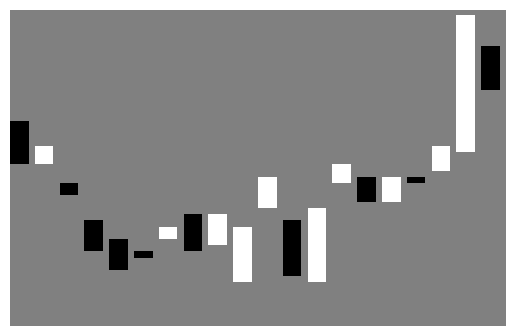

image number 1


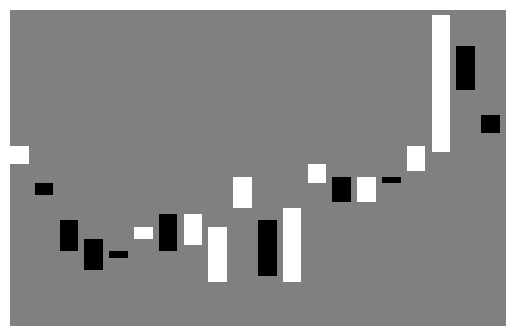

image number 2


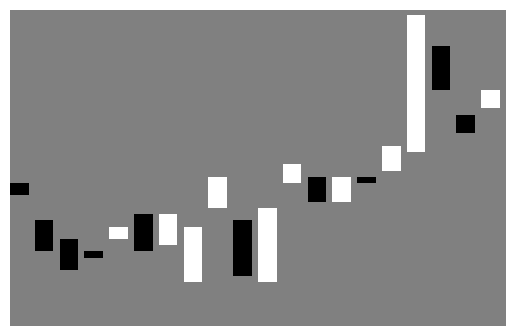

image number 3


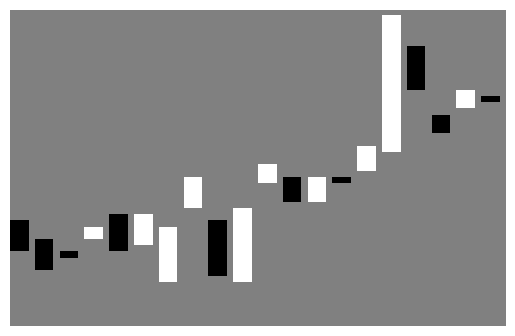

image number 4


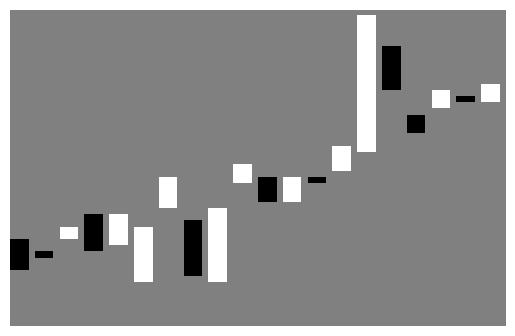

In [35]:
# visualize some images - EXAMPLE OF THE CANDLES 
from matplotlib import pyplot as plt
for i in range(5):
    print(f'image number {i}')
    plt.imshow(images_test_d["CL"]["candles"][i, :, :, 0], cmap='gray', vmin=0, vmax=255)
    plt.axis("off")
    plt.show()

### 4. Create the final images 

We generated two types of images based on our specific needs:

- Images of dimensions (51, 80, 4), where the four overlapping layers represent candlesticks, volumes, wicks, and a 5-day moving average.
- Images of dimensions (51, 80, 6), where the six overlapping layers represent candlesticks, volumes, wicks, and 5-day, 50-day, and 200-day moving averages.
The provided code demonstrates how to construct images with six layers. By commenting out the layers you don't wish to include, you can create images with different dimensions, focusing only on the financial characteristics deemed relevant.

With the following code it is possible to represent all the layers that will compose one image and the resulting plot. The latter will be represented with the compressed shape of (51, 80, 1) and not the real (51, 80, 6).

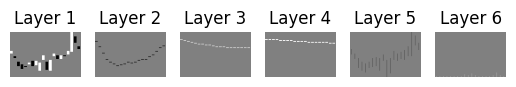

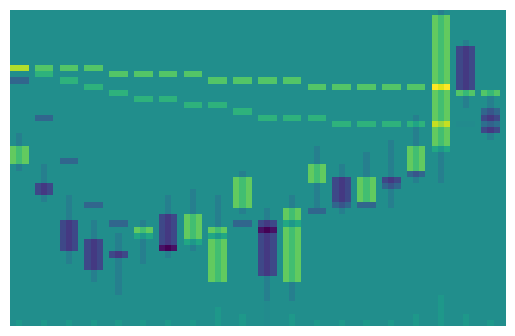

In [267]:

def overlay_images(images):
    # Ensure all images have the same shape
    for i in range(1, len(images)):
        assert images[i].shape == images[0].shape, "All images must have the same shape"

    # Stack the images along a new axis to create a new dimension
    composite_image = np.stack(images, axis=-1)

    return composite_image

if __name__ == "__main__":
    # Replace these vectors with your image vectors
    image1_vector = images_test_d["CL"]["candles"][1]  
    image2_vector = images_test_d["CL"]["ma"][1]
    image3_vector = images_test_d["CL"]["ma_50"][1]  
    image4_vector = images_test_d["CL"]["ma_200"][1]         
    image5_vector = images_test_d["CL"]["wicks"][1]    
    image6_vector = images_test_d["CL"]["volume"][1]   

    # Overlay the images
    images = [image1_vector, image2_vector, image3_vector, image4_vector,image5_vector, image6_vector]
    composite_image = overlay_images(images)

    # Remove the singleton dimension
    composite_image = np.squeeze(composite_image)

    # Display each layer separately
    for i in range(composite_image.shape[-1]):
        plt.subplot(1, composite_image.shape[-1], i + 1)
        plt.imshow(composite_image[:, :, i], cmap='gray', vmin=0, vmax=255)
        plt.axis('off')
        plt.title(f'Layer {i + 1}')

    plt.show()



# Convert to grayscale by averaging across channels
grayscale_image = np.mean(composite_image, axis=-1)

# Display the entire overlaid image in grayscale
plt.imshow(grayscale_image.astype(np.uint8)) #, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

The "overlay_images" function is able to overlap all the images we have created (each one of shape (51, 80, 1)) in only one image of shape (51, 80, 6).

In [183]:
def overlay_images(images):
    # Ensure all images have the same shape
    for i in range(1, len(images)):
        assert images[i].shape == images[0].shape, "All images must have the same shape"

    # Stack the images along a new axis to create a new dimension
    composite_image = np.stack(images, axis=-1)

    return composite_image

Here follows the code to create the whole training set.

In [185]:
composite_images_train_total = []  # List to store all composite images

# Assuming all vectors have the same length, you can loop over one of them

for ticker in tickers:
    if len(datasets_train[ticker]) != 0:
        #composite_images_train = []
        for i in range(len(images_train_d[ticker]["candles"])):
            # Take one image from each vector
            image1_vector = images_train_d[ticker]["candles"][i]
            image2_vector = images_train_d[ticker]["ma"][i]
            image3_vector = images_train_d[ticker]["ma_50"][1]  
            image4_vector = images_train_d[ticker]["ma_200"][1] 
            image5_vector = images_train_d[ticker]["wicks"][i]
            image6_vector = images_train_d[ticker]["volume"][i]

            # Overlay the images
            images = [image1_vector, image2_vector, image3_vector, image4_vector,image5_vector , image6_vector ]
            composite_image = overlay_images(images)

            # Remove the singleton dimension
            composite_image = np.squeeze(composite_image)

            # Append the composite image to the list
            #composite_images_train.append(composite_image)

            composite_images_train_total.append(composite_image)

# Convert the list of composite images to a numpy array
composite_images_array_train = np.stack(composite_images_train_total)

# Save the entire array of overlaid images in grayscale
np.save(f'composite_images_array_train_total6.npy', composite_images_array_train)

Here follows the code to create the whole testing set.

In [31]:
composite_images_test_total = []  # List to store all composite images

# Assuming all vectors have the same length, you can loop over one of them

for ticker in tickers:
    #composite_images_test = []
    for i in range(len(images_test_d[ticker]["candles"])):
        # Take one image from each vector
        image1_vector = images_test_d[ticker]["candles"][i]
        image2_vector = images_test_d[ticker]["ma"][i]
        image3_vector = images_test_d[ticker]["ma_50"][1]  
        image4_vector = images_test_d[ticker]["ma_200"][1] 
        image5_vector = images_test_d[ticker]["wicks"][i]
        image6_vector = images_test_d[ticker]["volume"][i]

        # Overlay the images
        images = [image1_vector, image2_vector, image3_vector, image4_vector, image5_vector , image6_vector]
        composite_image = overlay_images(images)

        # Remove the singleton dimension
        composite_image = np.squeeze(composite_image)

        # Append the composite image to the list
        #composite_images_test.append(composite_image)

        composite_images_test_total.append(composite_image)

# Convert the list of composite images to a numpy array
composite_images_array_test = np.stack(composite_images_test_total)

# Save the entire array of overlaid images in grayscale
np.save(f'composite_images_array_test_total5.npy', composite_images_array_test)

### 5. CNN (with images (51,80,4))

In [91]:
loaded_array_train = np.load('composite_images_array_train_total2.npy')
loaded_array_test = np.load('composite_images_array_test_total2.npy')

y_train = np.load('y_train_total.npy')
y_test = np.load('y_test_total.npy')


In [ ]:
batch_size = 256
epochs = 1000
learning_rate = 1e-4

# Define two callback functions for early stopping and learning rate reduction
callbacks=[
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=80, restore_best_weights=True, mode='max'),
    tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=30, min_lr=1e-7)
]

In [ ]:
# create a validation set

# Split the dataset into training and development sets
X_train, X_dev, y_train_, y_dev = train_test_split(
    loaded_array_train, 
    y_train, 
    test_size=0.2,  
    random_state=42  # Set a random seed for reproducibility
)

In [61]:
# Define a residual convolutional block with optional batch normalization
def conv_residual_block(x, filters, kernel_size, padding='same', downsample=True, activation='relu', stack=2, batch_norm=True, name=''):

    # If downsample is True, apply max-pooling
    if downsample:
        x = tfkl.MaxPooling2D(name='MaxPool_' + name)(x)

    # Create a copy of the input for the residual connection
    x_ = x

    # Apply a stack of convolutional layers to the copy
    for s in range(stack):
        x_ = tfkl.Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, name='Conv_' + name + str(s+1))(x_)
        if batch_norm:
            x_ = tfkl.BatchNormalization(name='BatchNorm_' + name + str(s+1))(x_)
        x_ = tfkl.Activation(activation, name='Activation_' + name + str(s+1))(x_)

    # If downsample is True, apply a 1x1 convolution to match the number of filters
    if downsample:
        x = tfkl.Conv2D(filters=filters, kernel_size=1, padding=padding, name='Conv_' + name + 'skip')(x)

    # Add the original and the processed copy to create the residual connection
    x = tfkl.Add(name='Add_' + name)([x_, x])

    return x

# Define a function to build a VGG18-like model with residual blocks
def build_model_residual(input_shape=(51, 80, 4), output_shape=1, learning_rate=1e-4):

    # Input layer
    input_layer = Input(shape=input_shape, name='Input_Layer')

    # Apply preprocessing to the input layer
    x0 = input_layer

    # Initial convolution with batch normalization and activation
    x0 = Conv2D(filters=64, kernel_size=3, padding='same', name='Conv0')(x0)
    x0 = BatchNormalization(name='BatchNorm0')(x0)
    x0 = tfkl.Activation('relu', name='ReLU0')(x0)

    # Create residual blocks
    x1 = conv_residual_block(x=x0, filters=64, kernel_size=3, downsample=False, stack=2, name='1')
    x1 = conv_residual_block(x=x1, filters=64, kernel_size=3, downsample=False, stack=2, name='2')

    x2 = conv_residual_block(x=x1, filters=128, kernel_size=3, downsample=True, stack=2, name='3')
    x2 = conv_residual_block(x=x2, filters=128, kernel_size=3, downsample=False, stack=2, name='4')

    x3 = conv_residual_block(x=x2, filters=256, kernel_size=3, downsample=True, stack=2, name='5')
    x3 = conv_residual_block(x=x3, filters=256, kernel_size=3, downsample=False, stack=2, name='6')

    x4 = conv_residual_block(x=x3, filters=512, kernel_size=3, downsample=True, stack=2, name='7')
    x4 = conv_residual_block(x=x4, filters=512, kernel_size=3, downsample=False, stack=2, name='8')

    # Global Average Pooling and classifier
    x = tfkl.GlobalAveragePooling2D(name='GlobalAveragePooling')(x4)
    x = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    output_activation = Dense(1, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=input_layer, outputs=output_activation, name='ResNet_VGG_Hybrid')

    # Define optimizer, loss, and metrics
    optimizer = tf.keras.optimizers.AdamW(learning_rate, weight_decay=5e-4)
    loss = tf.keras.losses.BinaryCrossentropy()
    metrics = ['accuracy']

    # Compile the model
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

# Build the hybrid model
hybrid_model = build_model_residual()
hybrid_model.summary()

Model: "ResNet_VGG_Hybrid"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_Layer (InputLayer)    [(None, 51, 80, 4)]          0         []                            
                                                                                                  
 Conv0 (Conv2D)              (None, 51, 80, 64)           2368      ['Input_Layer[0][0]']         
                                                                                                  
 BatchNorm0 (BatchNormaliza  (None, 51, 80, 64)           256       ['Conv0[0][0]']               
 tion)                                                                                            
                                                                                                  
 ReLU0 (Activation)          (None, 51, 80, 64)           0         ['BatchNorm0[0

In [119]:
# load the model to save time
model = load_model("hybrid_model.h5")

In [120]:
# Predict labels for the entire test set
predictions = model.predict(loaded_array_test)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

pred = np.where(predictions <= 0.5, 0, 1)

# Calculate accuracy score
accuracy = accuracy_score(y_test, pred.flatten())
print(f"Accuracy Score: {accuracy * 100:.2f}%")

243/243 [==============================] - 107s 437ms/step
Predictions Shape: (7756, 1)
Accuracy Score: 54.67%


### 6. Grad map

In [92]:
def GradCam(model, img_array, layer_name, eps=1e-8):
    gradModel = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        # Cast the image tensor to float-32 data type, pass the
        # image through the gradient model, and grab the loss
        # associated with the specific class index
        inputs = tf.cast(img_array, tf.float32)
        (convOutputs, predictions) = gradModel(inputs)
        loss = predictions[:, 0]

    # Use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)

    # Compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads

    # The convolution and guided gradients have a batch dimension
    # (which we don't need), so let's grab the volume itself and
    # discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]

    # Compute the average of the gradient values, and using them
    # as weights, compute the ponderation of the filters with
    # respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

    # Grab the spatial dimensions of the input image and resize
    # the output class activation map to match the input image
    # dimensions
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))

    # Normalize the heatmap such that all values lie in the range
    # [0, 1], scale the resulting values to the range [0, 255],
    # and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom

    return heatmap

def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def superimpose(img, cam, thresh, emphasize=False):
    '''
    Superimposes a grad-cam heatmap onto an image for model interpretation and visualization.
    
    Args:
      image: (img_width x img_height x 4) numpy array
      grad-cam heatmap: (img_width x img_width) numpy array
      threshold: float
      emphasize: boolean

    Returns 
      uint8 numpy array with shape (img_height, img_width, 3)
    '''
    # Convert the 4-channel image to 3-channel by dropping the fourth channel
    img_bgr = img[:, :, [0, 1,2]]

    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, thresh, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img_rgb


In [155]:
# Select 10 random images from the test set

index = random.sample(range(1, len(loaded_array_test)), 5)

images = loaded_array_test[index]

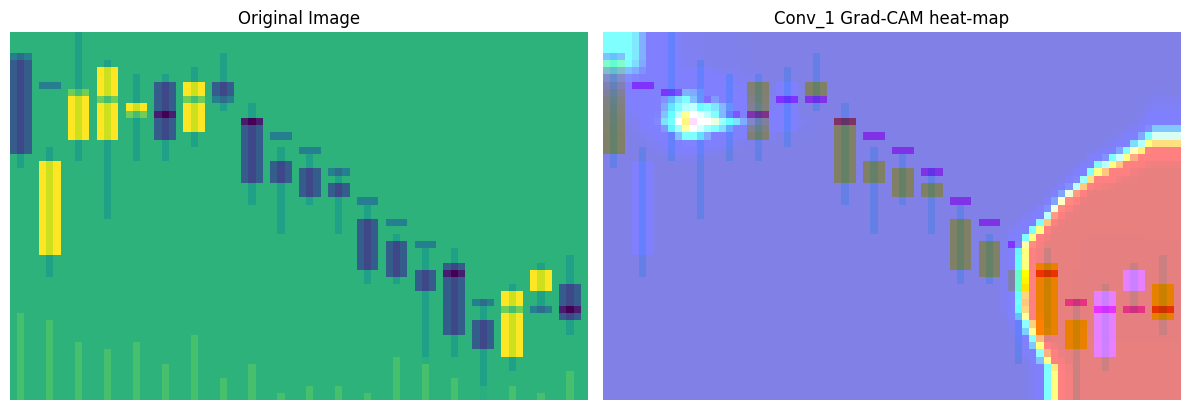

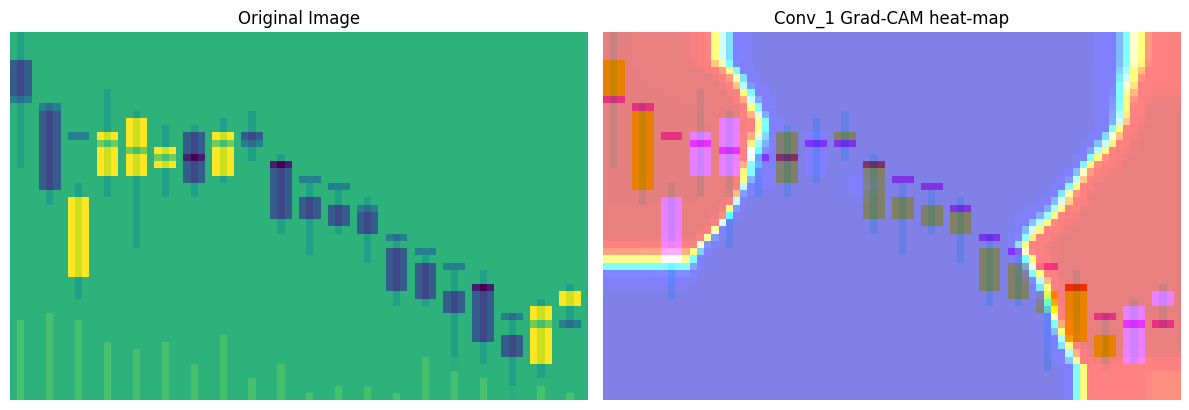

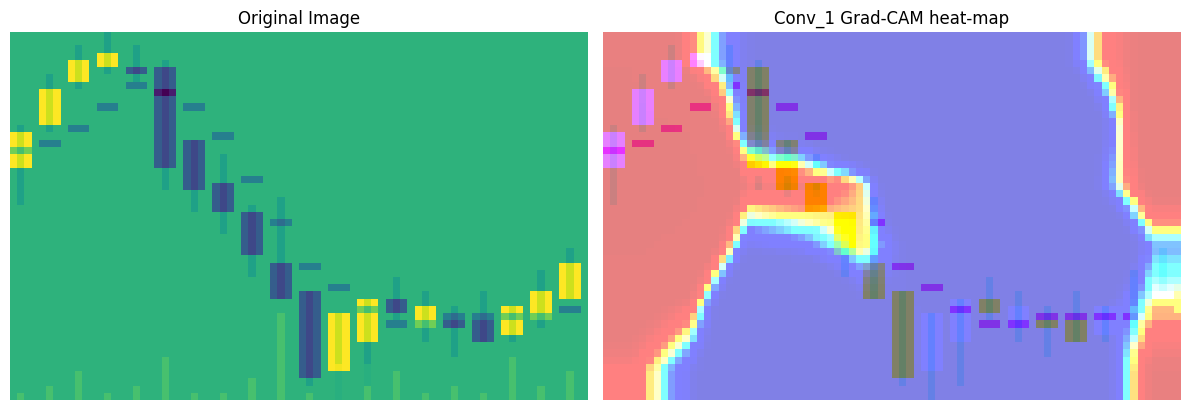

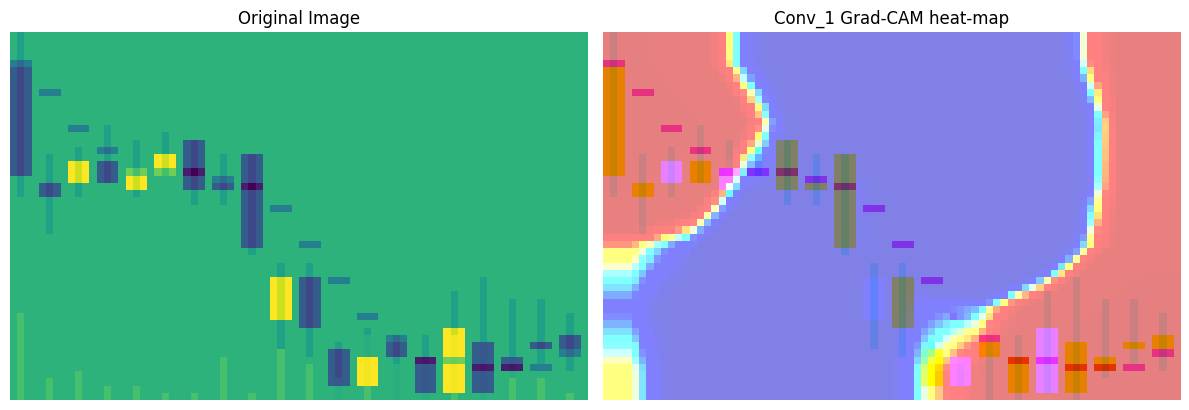

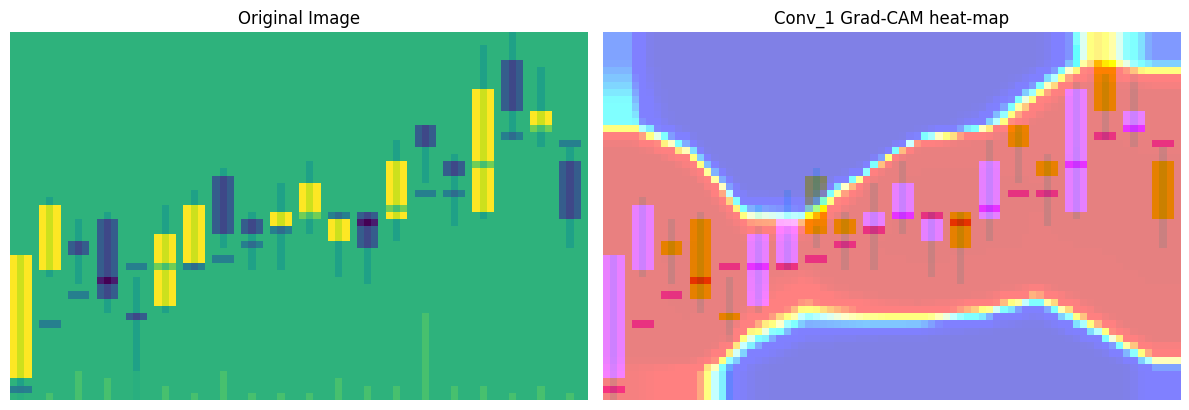

In [156]:
for img in images:
    layer_name = 'Conv_82'
    grad_cam=GradCam(model,np.expand_dims(img, axis=0),layer_name)
    grad_cam_superimposed = superimpose(img, grad_cam, 0.5, emphasize=True)


    plt.figure(figsize=(12, 5))
    ax = plt.subplot(1, 2, 1)
    plt.imshow(np.mean(img, axis=-1))
    plt.axis('off')
    plt.title('Original Image')
    ax = plt.subplot(1, 2, 2)
    plt.imshow(grad_cam_superimposed)
    plt.axis('off')
    plt.title('Conv_1 Grad-CAM heat-map')
    plt.tight_layout()

In [157]:
# Extract all the convolutional layers
conv2D_layers = [layer.name for layer in reversed(model2.layers) if len(layer.output_shape) == 4 and isinstance(layer, tf.keras.layers.Conv2D)]

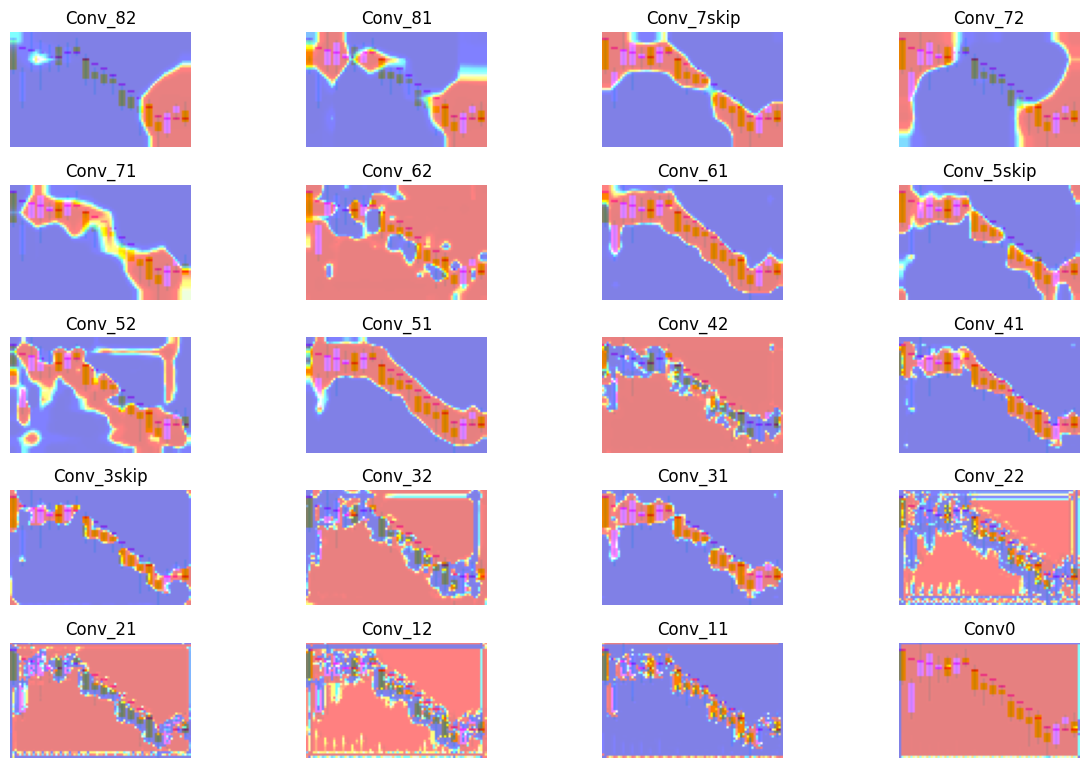

In [158]:
## Visualizing Convolution layers
plt.figure(figsize=(12, 20))
for i, layer in enumerate(conv2D_layers):
  grad_cam = GradCam(model2, np.expand_dims(images[0], axis=0), layer)
  grad_cam_emphasized = superimpose(images[0], grad_cam, 0.5, emphasize=True)
  ax = plt.subplot(13, 4, i +1)
  plt.imshow(grad_cam_emphasized)
  plt.title(layer)
  plt.axis("off")
plt.tight_layout()

### 7. Trading strategy

To test the utility of our work, we have implemented a trading strategy starting with only 1000 dollars, we invest every time all that we have. 
We have implemented a 5 days strategy, according to which we decide to buy or sell the commodity every 5 days, only looking at the prediction of our model. The performance is similar to the one obtained by our "lazy portfolio" benchmark, and it is better if we consider even shorter trading time ranges.

In [115]:
# here I do the prediction for the "CL" commodity

l = len(datasets_test["CL"])
images_CL_test = loaded_array_test[:l-20 ]

# Predict labels for the entire test set
predictions = model2.predict(images_CL_test)
pred = np.where(predictions <= 0.5, 0, 1)

df_test = datasets_test["CL"][20:].reset_index().drop(["index", "level_0"], axis = 1)
df_test["CNN_pred"]= pred.flatten()
 

61/61 [==============================] - 28s 447ms/step


In [167]:
# TRADING STRATEGY 
initial_wealth = 1000
current_wealth = initial_wealth
trade_interval = 5 # Trading every 5 days
wealth_over_time = []  # List of wealth values at the end of each trade interval
date = []  # List of dates corresponding to each wealth value
# Assume you either hold cash or commodity. If holding_commodity is True, you hold the commodity.
holding_commodity = False
purchase_price = 0

start_date = (df_test.iloc[0]['date'])
end_date = (df_test.iloc[-1]['date'])
total_days = (end_date - start_date).days
years = total_days / 365.25  #
trade_count = 0

for i in range(0, len(df_test) -1, trade_interval):
    current_data = df_test.iloc[i]
    current_data_tomorrow = df_test.iloc[i + 1]
    current_price = current_data['open']
    current_price_tomorrow = current_data_tomorrow['open']

    if current_data['CNN_pred'] == 1 and not holding_commodity:  # Buy commodity
        purchase_price = current_price_tomorrow.copy() # i buy the day after at opening since the last candle has been formed today
        holding_commodity = True
        trade_count +=1

    elif current_data['CNN_pred'] in [0, 2] and holding_commodity:  # Sell commodity
        sell_price = current_price_tomorrow.copy()
        holding_commodity = False
        profit = (sell_price - purchase_price) * (current_wealth / purchase_price)
        current_wealth += profit
        trade_count +=1

       
    wealth_over_time.append(current_wealth)
    date.append(current_data['date'])
# Calculate final wealth
if holding_commodity:
    # If still holding the commodity at the end, its value is based on the last price
    
    profit = (df_test.iloc[-1]['open'] - purchase_price) * (current_wealth / purchase_price)
    current_wealth += profit

# Append final wealth
wealth_over_time.append(current_wealth)
total_return = current_wealth - initial_wealth
percentage_return = (total_return / initial_wealth) * 100



# Calculate annualized return
annualized_return = ((current_wealth / initial_wealth) ** (1 / years)) - 1
annualized_return_percentage = annualized_return * 100

print(f"Final Wealth: {current_wealth}")
print(f"Total Return: {total_return} ({percentage_return}%)")
print(f"Annualized Return: {annualized_return_percentage}%")
print(f"Trade count over time: {trade_count}")

Final Wealth: 1062.8693187429274
Total Return: 62.86931874292736 (6.286931874292737%)
Annualized Return: 0.7956783587692362%
Trade count over time: 156


In [168]:
import plotly.graph_objects as go

# Create traces
trace1 = go.Scatter(
    x=list(range(len(wealth_over_time))),
    y=wealth_over_time,
    mode='lines',
    name='Without Transaction Costs'
)


# Define layout
layout = go.Layout(
    title='Wealth Over Time',
    xaxis=dict(title='Trade Intervals'),
    yaxis=dict(title='Wealth')
)

# Create figure and add traces
fig = go.Figure(data=trace1, layout=layout)

# Show the plot
fig.show()


In [169]:
# TRADING STRATEGY 
initial_wealth = 1000
current_wealth = initial_wealth
trade_interval = 1 # Trading every day
wealth_over_time = []  # List of wealth values at the end of each trade interval
date = []  # List of dates corresponding to each wealth value
# Assume you either hold cash or commodity. If holding_commodity is True, you hold the commodity.
holding_commodity = False
purchase_price = 0

start_date = (df_test.iloc[0]['date'])
end_date = (df_test.iloc[-1]['date'])
total_days = (end_date - start_date).days
years = total_days / 365.25  #
trade_count = 0

for i in range(0, len(df_test) -1, trade_interval):
    current_data = df_test.iloc[i]
    current_data_tomorrow = df_test.iloc[i + 1]
    current_price = current_data['open']
    current_price_tomorrow = current_data_tomorrow['open']

    if current_data['CNN_pred'] == 1 and not holding_commodity:  # Buy commodity
        purchase_price = current_price_tomorrow.copy() # i buy the day after at opening since the last candle has been formed today
        holding_commodity = True
        trade_count +=1

    elif current_data['CNN_pred'] in [0, 2] and holding_commodity:  # Sell commodity
        sell_price = current_price_tomorrow.copy()
        holding_commodity = False
        profit = (sell_price - purchase_price) * (current_wealth / purchase_price)
        current_wealth += profit
        trade_count +=1

       
    wealth_over_time.append(current_wealth)
    date.append(current_data['date'])
# Calculate final wealth
if holding_commodity:
    # If still holding the commodity at the end, its value is based on the last price
    
    profit = (df_test.iloc[-1]['open'] - purchase_price) * (current_wealth / purchase_price)
    current_wealth += profit

# Append final wealth
wealth_over_time.append(current_wealth)
total_return = current_wealth - initial_wealth
percentage_return = (total_return / initial_wealth) * 100



# Calculate annualized return
annualized_return = ((current_wealth / initial_wealth) ** (1 / years)) - 1
annualized_return_percentage = annualized_return * 100

print(f"Final Wealth: {current_wealth}")
print(f"Total Return: {total_return} ({percentage_return}%)")
print(f"Annualized Return: {annualized_return_percentage}%")
print(f"Trade count over time: {trade_count}")

Final Wealth: 1437.2501144219761
Total Return: 437.25011442197615 (43.72501144219761%)
Annualized Return: 4.827783402641783%
Trade count over time: 633


In [170]:
import plotly.graph_objects as go

# Create traces
trace1 = go.Scatter(
    x=list(range(len(wealth_over_time))),
    y=wealth_over_time,
    mode='lines',
    name='Without Transaction Costs'
)


# Define layout
layout = go.Layout(
    title='Wealth Over Time',
    xaxis=dict(title='Trade Intervals'),
    yaxis=dict(title='Wealth')
)

# Create figure and add traces
fig = go.Figure(data=trace1, layout=layout)

# Show the plot
fig.show()


In [55]:
# Lazy portfolio
open_price_firstday = df_test.iloc[0]['open']
open_price_lastday = df_test.iloc[-1]['open']
return_over_period = (open_price_lastday - open_price_firstday) / open_price_firstday
print(f"Return over period of the lazy portfolio: {np.round(return_over_period*100,2)} %")

Return over period of the lazy portfolio: 6.48 %
